In [6]:
import sys
sys.path.append("../")

import numpy as np
from scipy.special import erf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib.pylab as pylab
# from cycler import cycler
import palettable

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from plot_params import params

alpha_global = 0.7
pylab.rcParams.update(params)
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"

save_figs = True

cols = ['firebrick', 'cornflowerblue'] + palettable.wesanderson.FantasticFox2_5.hex_colors

In [2]:
# from sympy import *

# rho_dm = Symbol('\\rho_\mathrm{dm}')
# omega_l = Symbol('\Omega_l')
# M_0 = Symbol('M_0')
# R_0 = Symbol('R_0')
# D_l = Symbol('D_l')
# D_l_min = Symbol('D_l^\mathrm{min}')
# D_l_max = Symbol('D_l^\mathrm{max}')
# beta_0 = R_0 / D_l
# G_N = Symbol('G_\mathrm{N}')
# v = Symbol('v')
# ell = Symbol('\ell')

# Vol = integrate(4 * pi * D_l **2, (D_l, D_l_min, D_l_max))

# N_lens = omega_l * rho_dm * Vol / M_0

# C_ell = (4 * G_N * M_0 * v / D_l ** 2) ** 2 * (pi / 2) * exp(-ell ** 2 * beta_0 ** 2)

# C_ell_gaussian_pop = simplify(N_lens * integrate(4 * pi * D_l **2 * C_ell, (D_l, D_l_min, D_l_max)) / Vol)

# C_ell_gaussian_pop

In [3]:
# TODO: rewrite these properly and put in spec_calc.py!

def cl_gauss(M0, R0, v, Omega_l, l, Dl):
    return (1.130124740726684e-99*M0**2*v**2*np.exp(-((l**2*R0**2)/Dl**2)))/Dl**4

def cl_pop_gauss(M0, R0, v, Omega_l, l, Dlmin, Dlmax):
    return (-3.868196132832839e-116*M0*v**2*Omega_l*(erf((l*R0)/Dlmax) - erf((l*R0)/Dlmin)))/(l*R0)

def cl_pop_ps(M0, v, Omega_l, Dlmin, Dlmax):
    return 4.36479*10 ** -116 *(-(1/Dlmax) + 1/Dlmin)*M0*v**2*Omega_l

def cl_pop_ps_alpha(M0, v, Omega_l, l, Dlmin, Dlmax):
    return 4.341738820694676e-118*(-Dlmax**(-3) + Dlmin**(-3))*l**2*M0*v**4*Omega_l

def cl_pop_gauss_alpha(M0, R0, v, Omega_l, l, Dlmin, Dlmax):
    return 5.114990543587503e-118*l**2*M0*v**4*Omega_l*(((Dlmax**2/(l**2*R0**2))**1.5*(np.sqrt(np.pi) + 2/(Dlmax*np.exp((l**2*R0**2)/Dlmax**2)*np.sqrt(1/(l**2*R0**2))) - np.sqrt(np.pi)*erf(1/(Dlmax*np.sqrt(1/(l**2*R0**2))))))/Dlmax**3 - ((Dlmin**2/(l**2*R0**2))**1.5*(np.sqrt(np.pi) + 2/(Dlmin*np.exp((l**2*R0**2)/Dlmin**2)*np.sqrt(1/(l**2*R0**2))) - np.sqrt(np.pi)*erf(1/(Dlmin*np.sqrt(1/(l**2*R0**2))))))/Dlmin**3)

In [4]:
def F_single(M_0, R_0, v, Omega_l, l, D_l, sigma_mu, N_q):
    Cl = cl_gauss(M_0, R_0, v, Omega_l, l, D_l) / (asctorad / Year) **2 *1e12
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2


def F(M_0, R_0, v, Omega_l, l, D_min, D_max, sigma_mu, N_q):
    Cl = cl_pop_gauss(M_0, R_0, v, Omega_l, l, D_min, D_max) / (asctorad / Year) **2 *1e12
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2

def F_alpha(M_0, R_0, v, Omega_l, l, D_min, D_max, sigma_mu, N_q):
    Cl = cl_pop_gauss_alpha(M_0, R_0, v, Omega_l, l, D_min, D_max) / (asctorad / Year**2) **2 *1e12
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2


def F_ps(M_0, v, Omega_l, l, D_min, D_max, sigma_mu, N_q):
    Cl = np.array([cl_pop_ps(M_0, v, Omega_l, D_min, D_max) / (asctorad / Year) **2 *1e12]*len(l_ary))
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2

def F_ps_alpha(M_0, v, Omega_l, l, D_min, D_max, sigma_mu, N_q):
    Cl = cl_pop_ps_alpha(M_0, v, Omega_l, l, D_min, D_max) / (asctorad / Year**2) **2 *1e12
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2

In [13]:
sigma_alpha = 10
sigma_mu = 100
Dl = 1 * kpc
Dl_min = .1 * kpc
Dl_max = 10 * kpc
R_0 = 10 * pc
v_l = 1e-3
M_0 = 1e8 * M_s
N_q_alpha = 1e11
N_q_mu = 1e8

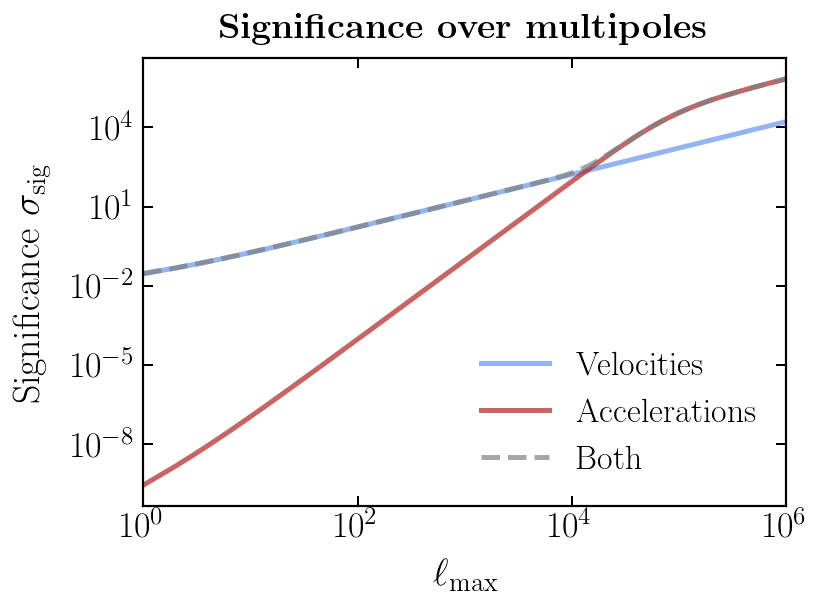

In [24]:
l_ary = np.arange(1,1e6)

plt.plot(l_ary, np.sqrt(np.cumsum(F_ps(M_0, v_l, 1, l_ary, Dl_min, Dl_max, sigma_mu, N_q_mu))), label=r'Velocities', color='cornflowerblue', alpha=alpha_global)
plt.plot(l_ary, np.sqrt(np.cumsum(F_ps_alpha(M_0, v_l, 1, l_ary, Dl_min, Dl_max, sigma_alpha, N_q_alpha))), label=r'Accelerations', color='firebrick', alpha=alpha_global)
plt.plot(l_ary, np.sqrt(np.cumsum(F_ps(M_0, v_l, 1, l_ary, Dl_min, Dl_max, sigma_mu, N_q_mu) + F_ps_alpha(M_0, v_l, 1, l_ary, Dl_min, Dl_max, sigma_alpha, N_q_alpha))), ls='--', label=r'Both', color='grey', alpha=alpha_global)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$\ell_\mathrm{max}$")
plt.ylabel('Significance $\sigma_\mathrm{sig}$')

plt.xlim(min(l_ary), max(l_ary))

plt.title(r"\textbf{Significance over multipoles}")

plt.legend(loc='lower right')

plt.tight_layout()

if save_figs:
    plt.savefig(plots_dir + "mualpha_compact.pdf")

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()


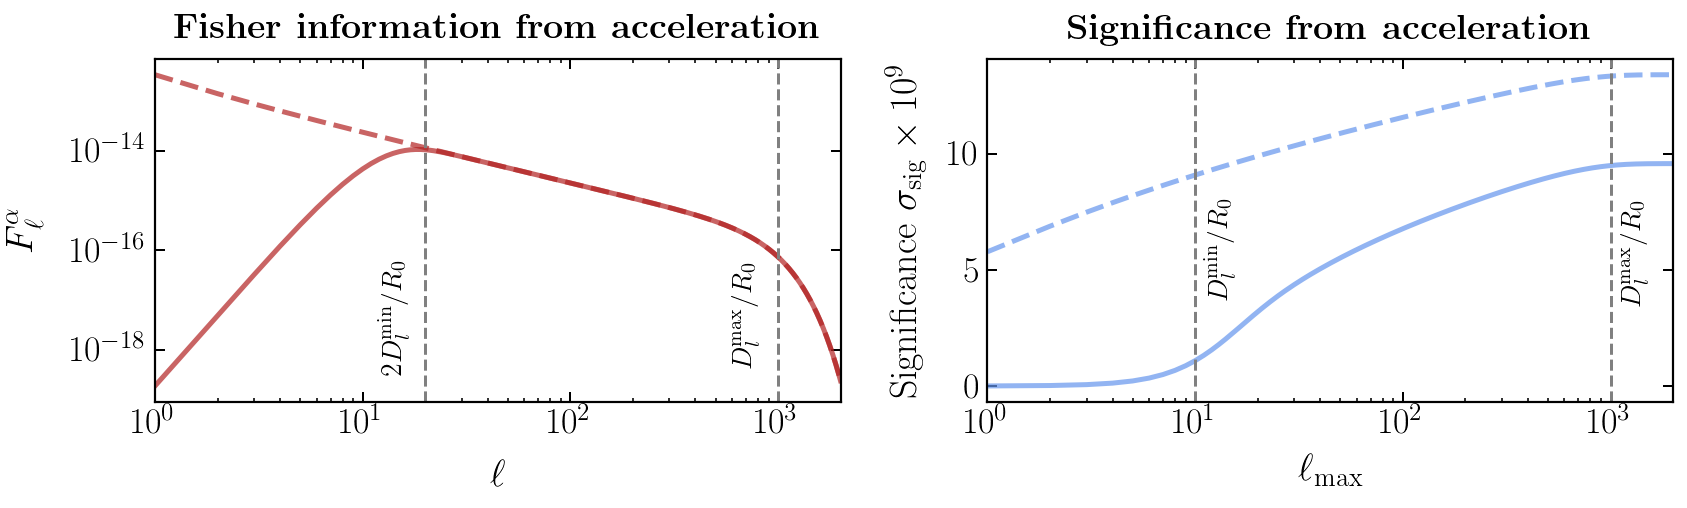

In [23]:
l_ary = np.arange(1,2000)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13/1.1,4/1.1))

ax1.plot(l_ary, F_alpha(M_0, R_0,  v_l, 1, l_ary, Dl_min, Dl_max, sigma_alpha, N_q_alpha), color=cols[0], alpha=alpha_global)
ax1.plot(l_ary, F_alpha(M_0, R_0,  v_l, 1, l_ary, 1e-12 * kpc, Dl_max, sigma_alpha, N_q_alpha), color=cols[0],ls='--', alpha=alpha_global)
ax1.axvline(2 * Dl_min / R_0, ls='--', color='grey', lw=1.5)
ax1.text(10** (np.log10(2 * Dl_min / R_0) - .2 ), 2e-17, '$2 D_l^\mathrm{min}/R_0$',rotation=90, fontsize=14)
ax1.axvline(Dl_max / R_0, ls='--', color='grey', lw=1.5)
ax1.text(10** (np.log10(Dl_max / R_0) - .2), 2e-17, '$D_l^\mathrm{max}/R_0$',rotation=90, fontsize=14)

ax1.set_xlabel('$\ell$')
ax1.set_ylabel(r'$F_\ell^{\alpha}$')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title(r"\textbf{Fisher information from acceleration}")

ax1.set_xlim(min(l_ary), max(l_ary))

ax2.plot(l_ary, np.sqrt(np.cumsum(F_alpha(M_0, R_0,  v_l, 1, l_ary, Dl_min, Dl_max, sigma_mu, N_q_alpha))) / 1e-9, color=cols[1], alpha=alpha_global)
ax2.plot(l_ary, np.sqrt(np.cumsum(F_alpha(M_0, R_0,  v_l, 1, l_ary, 1e-12 * kpc, Dl_max, sigma_mu, N_q_alpha))) / 1e-9, color=cols[1],ls='--', alpha=alpha_global)
ax2.axvline(Dl_max / R_0, ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl_max / R_0) + .07 ), 7e-9 / 1e-9, '$D_l^\mathrm{max}/R_0$',rotation=90, fontsize=14)
ax2.axvline(Dl_min / R_0, ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl_min / R_0) + .07 ), 7e-9 / 1e-9, '$D_l^\mathrm{min}/R_0$',rotation=90, fontsize=14)

ax2.set_xlabel('$\ell_\mathrm{max}$')
ax2.set_ylabel(r'Significance $\sigma_\mathrm{sig}\times 10^{9}$')

ax2.set_xscale("log")
# ax2.set_yscale("log")
ax2.set_title(r"\textbf{Significance from acceleration}")
ax2.set_xlim(min(l_ary), max(l_ary))

plt.tight_layout()

if save_figs:
    plt.savefig(plots_dir + "fisher_alpha.pdf")

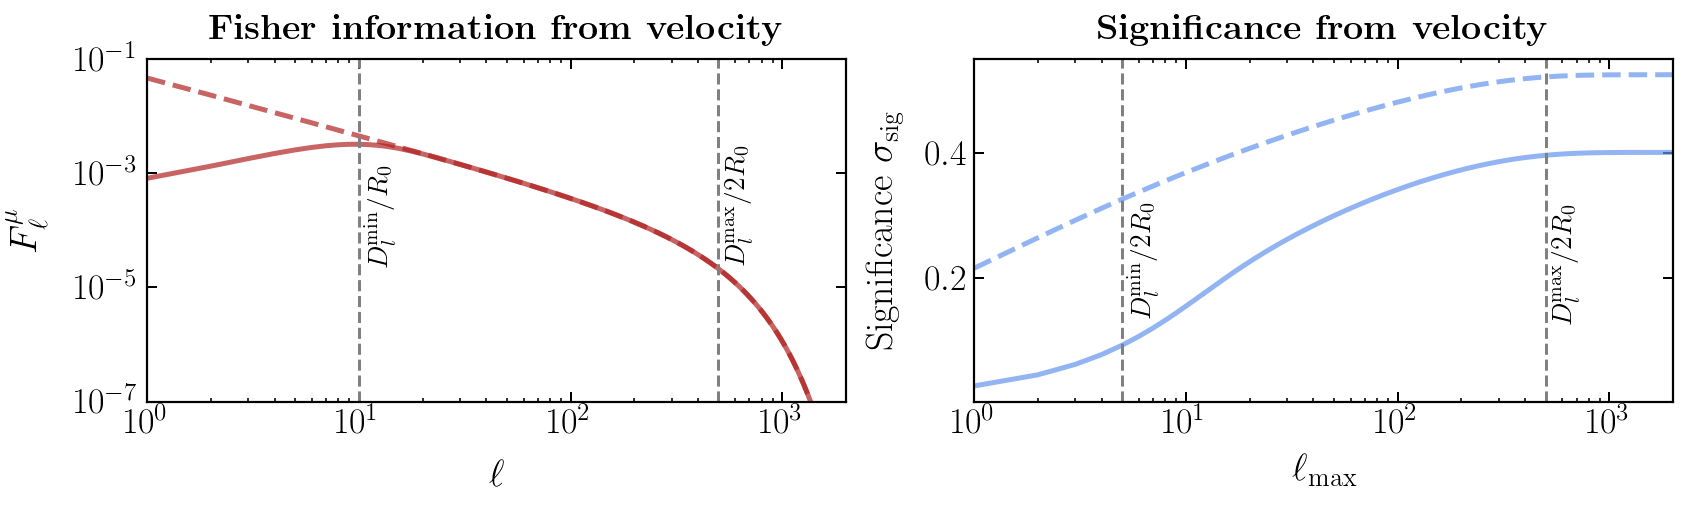

In [25]:
l_ary = np.arange(1,2000)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13/1.1,4/1.1))

ax1.plot(l_ary, F(M_0, R_0,  v_l, 1, l_ary, Dl_min, Dl_max, sigma_mu, N_q_mu), cols[0], alpha=alpha_global)
ax1.plot(l_ary, F(M_0, R_0,  v_l, 1, l_ary, 1e-22*kpc, Dl_max, sigma_mu, N_q_mu), cols[0],ls='--', alpha=alpha_global)
ax1.axvline(Dl_min / R_0, ls='--', color='grey', lw=1.5)
ax1.text(10** (np.log10(Dl_min / R_0) + .05 ), 5e-4, '$D_l^\mathrm{min}/R_0$',rotation=90, fontsize=14)
ax1.axvline(Dl_max / R_0 / 2., ls='--', color='grey', lw=1.5)
ax1.text(10** (np.log10(Dl_max / R_0 / 2.) + .05 ), 12e-4, '$D_l^\mathrm{max}/2R_0$',rotation=90, fontsize=14)

ax1.set_xlabel('$\ell$')
ax1.set_ylabel(r'$F_\ell^{\mu}$')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title(r"\textbf{Fisher information from velocity}")
ax1.set_xlim(min(l_ary), max(l_ary))
ax1.set_ylim(1e-7, .1)



ax2.plot(l_ary, np.sqrt(np.cumsum(F(M_0, R_0, v_l, 1, l_ary, Dl_min, Dl_max, sigma_mu, N_q_mu))), color=cols[1], alpha=alpha_global)
ax2.plot(l_ary, np.sqrt(np.cumsum(F(M_0, R_0, v_l, 1, l_ary, 1e-12*kpc, Dl_max, sigma_mu, N_q_mu))), color=cols[1],ls='--', alpha=alpha_global)

ax2.axvline(Dl_max / (2 * R_0), ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl_max / (2 * R_0)) + .05 ), .28, '$D_l^\mathrm{max}/ 2R_0$',rotation=90, fontsize=14)
ax2.axvline(Dl_min / (2 * R_0), ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl_min / (2 * R_0)) + .05 ), .28, '$D_l^\mathrm{min}/ 2R_0$',rotation=90, fontsize=14)

ax2.set_xlabel('$\ell_\mathrm{max}$')
ax2.set_ylabel('Significance $\sigma_\mathrm{sig}$')
ax2.set_xscale("log")
# ax2.set_yscale("log")

ax2.set_title(r"\textbf{Significance from velocity}")
ax2.set_xlim(min(l_ary), max(l_ary))

plt.tight_layout()

if save_figs:
    plt.savefig(plots_dir + "fisher_mu.pdf")

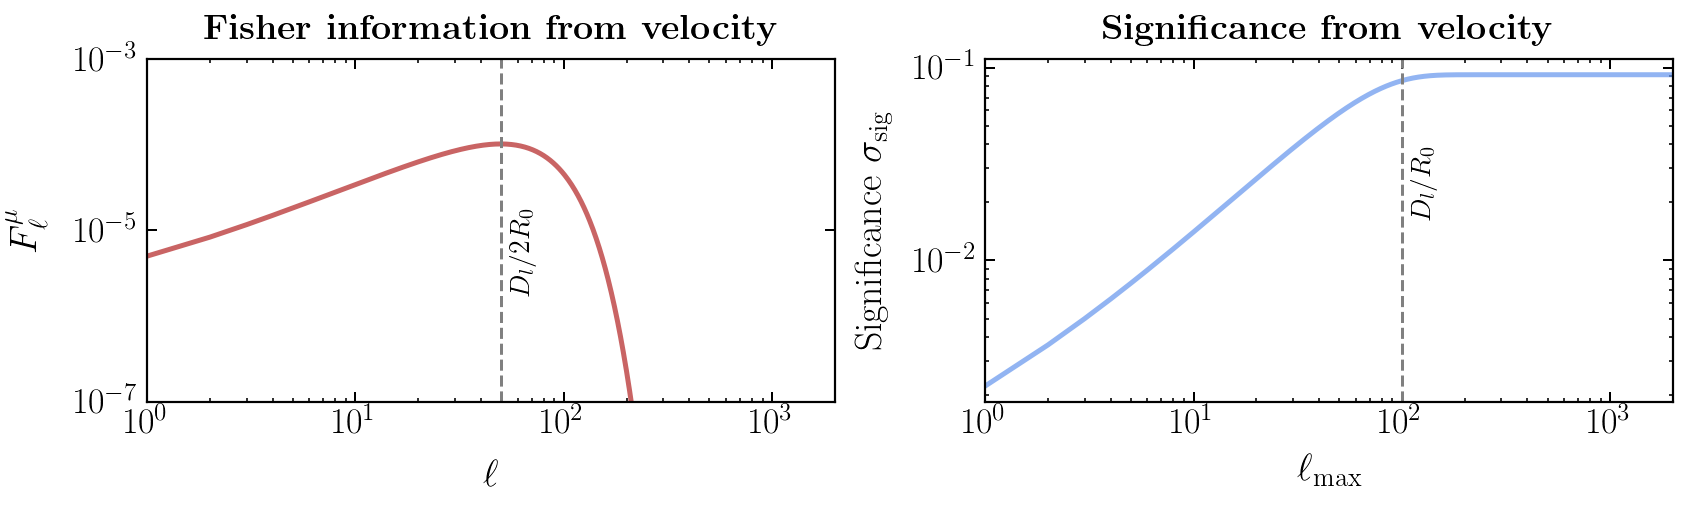

In [26]:
l_ary = np.arange(1,2000)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13/1.1,4/1.1))

ax1.plot(l_ary, F_single(M_0, R_0, v_l, 1, l_ary, Dl, sigma_mu, N_q_mu), color=cols[0], alpha=alpha_global)
ax1.axvline(0.5 * Dl / R_0, ls='--', color='grey', lw=1.5)
ax1.text(10** (np.log10(0.5 * Dl / R_0) + .05 ), 1e-5, '$D_l/2R_0$',rotation=90, fontsize=14)

ax1.set_xlabel('$\ell$')
ax1.set_ylabel(r'$F_\ell^{\mu}$')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title(r"\textbf{Fisher information from velocity}")
ax1.set_xlim(min(l_ary), max(l_ary))
ax1.set_ylim(1e-7,1e-3)

ax2.plot(l_ary, np.sqrt(np.cumsum(F_single(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl, sigma_mu, 1e8))), color=cols[1], alpha=alpha_global)
ax2.axvline(Dl / (R_0), ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl / R_0) + .05 ), 3e-2, '$D_l/R_0$',rotation=90, fontsize=14)

ax2.set_xlabel('$\ell_\mathrm{max}$')
ax2.set_ylabel('Significance $\sigma_\mathrm{sig}$')
ax2.set_xscale("log")
ax2.set_yscale("log")

ax2.set_title(r"\textbf{Significance from velocity}")
ax2.set_xlim(min(l_ary), max(l_ary))

plt.tight_layout()

if save_figs:
    plt.savefig(plots_dir + "fisher_mu_single.pdf")

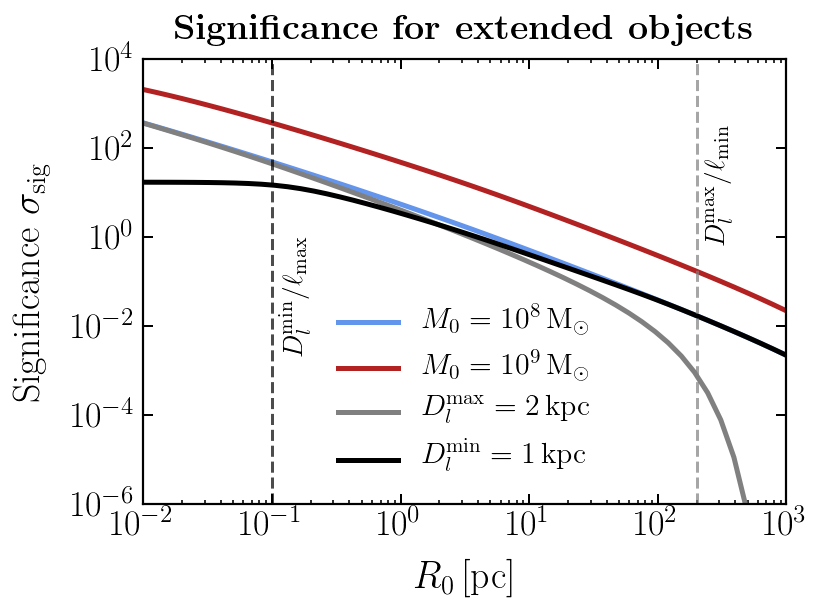

In [38]:
l_ary = np.arange(10,1e4)

R_0_ary = np.logspace(-2,3) * pc
F_R_0_1_ary = []
F_R_0_1_1_ary = []
F_R_0_2_ary = []
F_R_0_3_ary = []

for R_0 in R_0_ary:
    F_R_0_1_ary.append(np.sqrt(np.sum(F(1e8 * M_s, R_0,  v_l, 1, l_ary, 1e-12*kpc, 100*kpc, sigma_mu, 1e8))))
    F_R_0_1_1_ary.append(np.sqrt(np.sum(F(1e9 * M_s, R_0,  v_l, 1, l_ary, 1e-12*kpc, 100*kpc, sigma_mu, 1e8))))
    F_R_0_2_ary.append(np.sqrt(np.sum(F(1e8 * M_s, R_0,  v_l, 1, l_ary, 1e-12*kpc, 2*kpc, sigma_mu, 1e8))))
    F_R_0_3_ary.append(np.sqrt(np.sum(F(1e8 * M_s, R_0,  v_l, 1, l_ary, 1*kpc, 100*kpc, sigma_mu, 1e8))))

plt.figure()
plt.plot(R_0_ary/ pc, F_R_0_1_ary, label=r'$M_0 = 10^8\,\mathrm{M}_\odot$', color='cornflowerblue')
plt.plot(R_0_ary/ pc, F_R_0_1_1_ary, label=r'$M_0 = 10^9\,\mathrm{M}_\odot$', color='firebrick')
plt.plot(R_0_ary/ pc, F_R_0_2_ary, label=r'$D_l^\mathrm{max} = 2$\,kpc', color='grey')
plt.plot(R_0_ary/ pc, F_R_0_3_ary, label=r'$D_l^\mathrm{min} = 1$\,kpc', color='black')

plt.axvline(1*kpc/np.max(l_ary)/pc, ls='--', color='black', alpha=0.7, lw=1.5)
plt.axvline(2*kpc/np.min(l_ary)/pc, ls='--', color='grey', alpha=0.7, lw=1.5)

plt.text(10 ** (np.log10(1*kpc/np.max(l_ary)/pc) + .1 ), .28, r'$D_l^\mathrm{min}/ \ell_\mathrm{max}$',rotation=90, fontsize=14)
plt.text(10 ** (np.log10(2*kpc/np.min(l_ary)/pc) + .1 ), 100, r'$D_l^\mathrm{max}/ \ell_\mathrm{min}$',rotation=90, fontsize=14)


plt.xlabel('$R_0$\,[pc]')
plt.ylabel('Significance $\sigma_\mathrm{sig}$')

plt.xscale("log")
plt.yscale("log")

plt.xlim(min(R_0_ary/pc), max(R_0_ary/pc))
plt.ylim(1e-6,1e4)

plt.title((r"\textbf{Significance for extended objects}"))

plt.legend(fancybox=True, frameon=False, fontsize=15, loc='lower center', ncol=1)

plt.tight_layout()

if save_figs:
    plt.savefig(plots_dir + "sig_R0.pdf")

In [ ]:
# l_ary = np.arange(10,1e4)
# R_0_ary = np.logspace(-2,3) * pc
# F_R_0_1_ary = []
# F_R_0_2_ary = []
# F_R_0_3_ary = []

# for R_0 in R_0_ary:
#     F_R_0_1_ary.append(np.sqrt(np.sum(F_single(1e8 * M_s, R_0,  v_l, 1, l_ary, Dl, sigma_mu, N_q_mu))))
#     F_R_0_2_ary.append(np.sqrt(np.sum(F_single(1e7 * M_s, R_0,  v_l, 1, l_ary, Dl, sigma_mu, N_q_mu))))

# plt.figure()
# plt.plot(R_0_ary/ pc, F_R_0_1_ary, label=r'$M_0 = 10^8\,\mathrm{M}_\odot$')
# plt.plot(R_0_ary/ pc, F_R_0_2_ary, label=r'$M_0 = 10^7\,\mathrm{M}_\odot$')

# plt.axvline(Dl/np.max(l_ary)/pc, ls='--', color='grey', lw=1.5)
# plt.axvline(Dl/np.min(l_ary)/pc, ls='--', color='grey', lw=1.5)
# plt.text(10** (np.log10(Dl/np.max(l_ary)/pc) + .1 ), 1e-3, '$D_l/\ell_\mathrm{max}$',rotation=90, fontsize=14)
# plt.text(10** (np.log10(Dl/np.min(l_ary)/pc) + .1 ), 1e-1, '$D_l/\ell_\mathrm{min}$',rotation=90, fontsize=14)

# plt.xlabel('$R_0$\,[pc]')
# plt.ylabel('Significance $\sigma_\mathrm{sig}$')
# plt.xscale("log")
# plt.yscale("log")

# plt.xlim(min(R_0_ary/pc), max(R_0_ary/pc))
# plt.ylim(1e-7,100)

# plt.legend()
# plt.title((r"\textbf{Significance for extended objects}"))

# plt.tight_layout()

# if save_figs:
#     plt.savefig(plots_dir + "sig_R0.pdf")

In [70]:
# Dl_min = 1e-4 * kpc

# Dl_max_ary = np.logspace(0,3,1000)*kpc
# F_ary = []
# for Dl_max in Dl_max_ary:
#     l_ary = np.arange(1,Dl_max/R_0)
#     F_ary.append(np.sqrt(np.sum(F_alpha(1e2 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8))))
    
# plt.plot(Dl_max_ary/kpc, F_ary)
# plt.xscale("log")

# plt.xlabel(r"$D_l^\mathrm{max}$")
# plt.ylabel(r"$\sigma_\mu(\ell_\mathrm{max}=D_l^\mathrm{max}/R_0$)")

# plt.xlim(min(Dl_max_ary/kpc), max(Dl_max_ary/kpc))